# **Generative Answer Chat Bot**

In [98]:
import re
import time
from tqdm.auto import tqdm

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords as nltk_stopwords

import torch
from transformers import BertForQuestionAnswering, BertTokenizer
from sentence_transformers import SentenceTransformer

In [99]:
questions = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Questions.csv', parse_dates = True, encoding='latin-1')
answers = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Answers.csv', parse_dates=True, encoding='latin-1')
tags = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Tags.csv', encoding='latin-1')

In [100]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607282 entries, 0 to 607281
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            607282 non-null  int64  
 1   OwnerUserId   601070 non-null  float64
 2   CreationDate  607282 non-null  object 
 3   Score         607282 non-null  int64  
 4   Title         607282 non-null  object 
 5   Body          607282 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 27.8+ MB


In [101]:
answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            987122 non-null  int64  
 1   OwnerUserId   981755 non-null  float64
 2   CreationDate  987122 non-null  object 
 3   ParentId      987122 non-null  int64  
 4   Score         987122 non-null  int64  
 5   Body          987122 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 45.2+ MB


In [102]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885078 entries, 0 to 1885077
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 28.8+ MB


In [103]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [104]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


In [105]:
tags.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


## **Prepare Data**

### Convert columns to snake case

In [106]:
# Questions columns
questions.columns = (questions.columns
                     .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                     .str.lower())

questions.columns

Index(['id', 'owner_user_id', 'creation_date', 'score', 'title', 'body'], dtype='object')

In [107]:
# Answers columns
answers.columns = (answers.columns
                   .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                   .str.lower())

answers.columns

Index(['id', 'owner_user_id', 'creation_date', 'parent_id', 'score', 'body'], dtype='object')

In [108]:
# Tags columns
tags.columns = tags.columns.str.lower()

tags.columns

Index(['id', 'tag'], dtype='object')

### Convert to datetime

In [109]:
# Questions date to datetime
questions['creation_date'] = pd.to_datetime(questions['creation_date'])

display(questions.head())
questions.info()

,id,owner_user_id,creation_date,score,title,body
0,469,147.0,2008-08-02 15:11:16+00:00,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02 17:01:58+00:00,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02 18:43:54+00:00,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03 01:15:08+00:00,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03 13:19:16+00:00,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607282 entries, 0 to 607281
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   id             607282 non-null  int64              
 1   owner_user_id  601070 non-null  float64            
 2   creation_date  607282 non-null  datetime64[ns, UTC]
 3   score          607282 non-null  int64              
 4   title          607282 non-null  object             
 5   body           607282 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(2)
memory usage: 27.8+ MB


In [110]:
# Answers date to datetime
answers['creation_date'] = pd.to_datetime(answers['creation_date'])

display(answers.head())
answers.info()

,id,owner_user_id,creation_date,parent_id,score,body
0,497,50.0,2008-08-02 16:56:53+00:00,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02 17:42:28+00:00,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02 18:49:07+00:00,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02 18:56:56+00:00,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02 19:06:40+00:00,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   id             987122 non-null  int64              
 1   owner_user_id  981755 non-null  float64            
 2   creation_date  987122 non-null  datetime64[ns, UTC]
 3   parent_id      987122 non-null  int64              
 4   score          987122 non-null  int64              
 5   body           987122 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(1)
memory usage: 45.2+ MB


### Missing values

In [111]:
questions.isna().sum()

id                  0
owner_user_id    6212
creation_date       0
score               0
title               0
body                0
dtype: int64

In [112]:
answers.isna().sum()

id                  0
owner_user_id    5367
creation_date       0
parent_id           0
score               0
body                0
dtype: int64

### Duplicates

In [113]:
# Questions duplicates
print(f'Number of questions duplicates: {questions.duplicated().sum()}')

Number of questions duplicates: 0


In [114]:
# Ansers duplicates
print(f'Number of answer duplicates: {answers.duplicated().sum()}')

Number of answer duplicates: 0


### Normalize text

In [115]:
# View text example
print(questions.loc[1, 'body'])
print(questions.loc[2, 'body'])

print(answers.loc[1, 'body'])
print(answers.loc[2, 'body'])

<p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>

<p>On the Mac I am spawning <a href="http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html">sips</a>.  Is there something similarly simple I can do on Windows?</p>

<p>I'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (i.e. running a battery of test-cases each time a check-in is made and sending nag e-mails to responsible persons when the tests fail) similar to CruiseControl or TeamCity.</p>

<p>I realize I could do this with hooks in most VCSes, but that requires that the tests run on the same machine as the version control server, which isn't as elegant as I would like. Does anyone have any suggestions for a small, user-friendly, open-source continuous integration system suitable for a Python codebase?</p>

<p>I haven't been able to find anything that does this direc

In [116]:
# Define normalizing function
def normalize_text(text):
    text = text.lower()
    text = text.replace('<p>', ' ')
    text = text.replace('</p>', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('<a', ' ')
    text = text.replace('</a>', ' ')
    text = text.replace('href=', ' ')
    text = text.replace('</code', ' ')
    text = text.replace('</pre>', ' ')
    text = text.replace('<code>', ' ')
    text = text.replace('jpeg', ' ')
    text = text.replace('jpg', ' ')
    text = text.replace('pre', ' ')
    text = text.replace('pdf', ' ')
    text = text.replace('gt', ' ')
    text = re.sub(r"[^a-zA-z']", ' ', text)
    text = text.split()
    text = " ".join(text)
    
    return text

def normalize_with_sentences(text):
    text = text.lower()
    text = text.replace('<p>', ' ')
    text = text.replace('</p>', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('<a', ' ')
    text = text.replace('</a>', ' ')
    text = text.replace('href=', ' ')
    text = text.replace('</code', ' ')
    text = text.replace('</pre>', ' ')
    text = text.replace('<code>', ' ')
    text = text.replace('jpeg', ' ')
    text = text.replace('jpg', ' ')
    text = text.replace('pre', ' ')
    text = text.replace('pdf', ' ')
    text = text.replace('gt', ' ')
    text = re.sub(r"[^a-zA-z'.]", ' ', text)
    text = text.split()
    text = " ".join(text)
    
    return text

# Apply normalization to Q title and Q & A body
questions['body_normalized'] = questions['body'].apply(normalize_text)
questions['title_normalized'] = questions['title'].apply(normalize_text)
answers['body_normalized'] = answers['body'].apply(normalize_text)

questions['body_with_sentences'] = questions['body'].apply(normalize_with_sentences)
questions['title_with_sentences'] = questions['title'].apply(normalize_with_sentences)
answers['body_with_sentences'] = answers['body'].apply(normalize_with_sentences)

In [117]:
# View examples normalized
print(questions.loc[1, 'title_normalized'])
print(questions.loc[1, 'body_normalized'])
print(answers.loc[1, 'body_normalized'])

get a view of a on windows
i have a cross platform python application which needs to generate a view of the first page of a on the mac i am spawning http developer apple com documentation darwin reference manpages man sips html sips is there something similarly simple i can do on windows
i haven't been able to find anything that does this directly i think you'll have to iterate through the various font folders on the system system library fonts library fonts and there can probably be a user level directory as well library fonts


### Add year column

In [118]:
# Question year
questions['creation_year'] = questions['creation_date'].dt.year

questions.head()

,id,owner_user_id,creation_date,score,title,body,body_normalized,title_normalized,body_with_sentences,title_with_sentences,creation_year
0,469,147.0,2008-08-02 15:11:16+00:00,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,i am using the photoshop's javascript api to f...,how can i find the full path to a font from it...,i am using the photoshop's javascript api to f...,how can i find the full path to a font from it...,2008
1,502,147.0,2008-08-02 17:01:58+00:00,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,i have a cross platform python application whi...,get a view of a on windows,i have a cross platform python application whi...,get a view of a on windows,2008
2,535,154.0,2008-08-02 18:43:54+00:00,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,i'm starting work on a hobby project with a py...,continuous integration system for a python cod...,i'm starting work on a hobby project with a py...,continuous integration system for a python cod...,2008
3,594,116.0,2008-08-03 01:15:08+00:00,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,there are several ways to iterate over a resul...,cx_oracle how do i iterate over a result set,there are several ways to iterate over a resul...,cx_oracle how do i iterate over a result set,2008
4,683,199.0,2008-08-03 13:19:16+00:00,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,i don't remember whether i was dreaming or not...,using 'in' to match an attribute of python obj...,i don't remember whether i was dreaming or not...,using 'in' to match an attribute of python obj...,2008


In [119]:
# Answer year
answers['creation_year'] = answers['creation_date'].dt.year

answers.head()

,id,owner_user_id,creation_date,parent_id,score,body,body_normalized,body_with_sentences,creation_year
0,497,50.0,2008-08-02 16:56:53+00:00,469,4,<p>open up a terminal (Applications-&gt;Utilit...,open up a terminal applications utilities term...,open up a terminal applications utilities term...,2008
1,518,153.0,2008-08-02 17:42:28+00:00,469,2,<p>I haven't been able to find anything that d...,i haven't been able to find anything that does...,i haven't been able to find anything that does...,2008
2,536,161.0,2008-08-02 18:49:07+00:00,502,9,<p>You can use ImageMagick's convert utility f...,you can use imagemagick's convert utility for ...,you can use imagemagick's convert utility for ...,2008
3,538,156.0,2008-08-02 18:56:56+00:00,535,23,<p>One possibility is Hudson. It's written in...,one possibility is hudson it's written in java...,one possibility is hudson. it's written in jav...,2008
4,541,157.0,2008-08-02 19:06:40+00:00,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B...",we run http buildbot net trac buildbot trac at...,we run http buildbot.net trac buildbot trac at...,2008


### Merge QA dataframes

In [120]:
# Merge answers onto questions
df_QA = questions.merge(answers, left_on='id', right_on='parent_id', how='outer',
                        suffixes=('_q', '_a'))

In [121]:
# QA dataframe info
df_QA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055166 entries, 0 to 1055165
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   id_q                   1055166 non-null  int64              
 1   owner_user_id_q        1041567 non-null  float64            
 2   creation_date_q        1055166 non-null  datetime64[ns, UTC]
 3   score_q                1055166 non-null  int64              
 4   title                  1055166 non-null  object             
 5   body_q                 1055166 non-null  object             
 6   body_normalized_q      1055166 non-null  object             
 7   title_normalized       1055166 non-null  object             
 8   body_with_sentences_q  1055166 non-null  object             
 9   title_with_sentences   1055166 non-null  object             
 10  creation_year_q        1055166 non-null  int32              
 11  id_a                   9

In [122]:
# QA dataframe sample
df_QA.sample(15)

,id_q,owner_user_id_q,creation_date_q,score_q,title,body_q,body_normalized_q,title_normalized,body_with_sentences_q,title_with_sentences,creation_year_q,id_a,owner_user_id_a,creation_date_a,parent_id,score_a,body_a,body_normalized_a,body_with_sentences_a,creation_year_a
616137,25584748,3027800.0,2014-08-30 16:53:16+00:00,-1,How to split a string into a list but not brac...,<p>Sorry about the title - I wasn't sure how t...,sorry about the title i wasn't sure how to wor...,how to split a string into a list but not brac...,sorry about the title i wasn't sure how to wor...,how to split a string into a list but not brac...,2014,25586565.0,3503502.0,2014-08-30 20:40:23+00:00,25584748.0,0.0,<p>I believe this dodgy code works similar to ...,i believe this dodgy code works similar to wha...,i believe this dodgy code works similar to wha...,2014.0
485201,20282201,656392.0,2013-11-29 09:23:19+00:00,1,Search for Error Elements in Selenium After .s...,<p>I have some selenium code to input various ...,i have some selenium code to input various sea...,search for error elements in selenium after su...,i have some selenium code to input various sea...,search for error elements in selenium after .s...,2013,20306537.0,656392.0,2013-11-30 22:47:53+00:00,20282201.0,0.0,<p>I found a solution that seems to work prett...,i found a solution that seems to work tty well...,i found a solution that seems to work tty well...,2013.0
728185,29794617,4813969.0,2015-04-22 10:25:40+00:00,0,Internal server error 500 after launching flas...,"<p>I am following the tutorial: <a href=""https...",i am following the tutorial https pythonhosted...,internal server error after launching flask py...,i am following the tutorial https pythonhosted...,internal server error after launching flask py...,2015,29820790.0,2390826.0,2015-04-23 10:30:43+00:00,29794617.0,0.0,"<p>It's better to set ""app.debug = True"" to ge...",it's better to set app debug true to get an er...,it's better to set app.debug true to get an er...,2015.0
596302,24806264,3845621.0,2014-07-17 14:26:46+00:00,-2,Changing only one letter when there are a lot ...,<p>Suppose I have the following string:</p>\n\...,suppose i have the following string i like foo...,changing only one letter when there are a lot ...,suppose i have the following string i.like.foo...,changing only one letter when there are a lot ...,2014,24806343.0,1545322.0,2014-07-17 14:30:39+00:00,24806264.0,1.0,<pre><code>str='I.like.football'\n\nstr=str.rs...,str 'i like football' str str rsplit ' ' this ...,str 'i.like.football' str str.rsplit '.' this ...,2014.0
844625,33721035,5564468.0,2015-11-15 14:51:19+00:00,0,python looping with functions break and contin...,<p>I am new to programming and so i'm practici...,i am new to programming and so i'm practicing ...,python looping with functions break and contin...,i am new to programming and so i'm practicing ...,python looping with functions break and contin...,2015,33721307.0,5542531.0,2015-11-15 15:18:09+00:00,33721035.0,0.0,"<p>Because you are new to programming, I will ...",because you are new to programming i will get ...,because you are new to programming i will get ...,2015.0
813618,32737134,2689928.0,2015-09-23 10:28:02+00:00,3,Extract a column from a list of rows with Python,"<p>I have the following dataset, which is a se...",i have the following dataset which is a series...,extract a column from a list of rows with python,i have the following dataset which is a series...,extract a column from a list of rows with python,2015,32737298.0,4251775.0,2015-09-23 10:35:29+00:00,32737134.0,5.0,<p>Change in you own code:</p>\n\n<p>Python 3....,change in you own code python x set list zip l...,change in you own code python .x set list zip ...,2015.0
1049790,39993921,5436714.0,2016-10-12 08:28:35+00:00,2,Match a substring in Pandas wit str.extract me...,<p>I have a string looking like:</p>\n\n<pre><...,i have a string looking like i want to extract...,match a substring in pandas wit str extract me..

In [123]:
# QA dataframe missing
print('Missing QA Dataframe')
df_QA.isna().sum()

Missing QA Dataframe


id_q                         0
owner_user_id_q          13599
creation_date_q              0
score_q                      0
title                        0
body_q                       0
body_normalized_q            0
title_normalized             0
body_with_sentences_q        0
title_with_sentences         0
creation_year_q              0
id_a                     68044
owner_user_id_a          73411
creation_date_a          68044
parent_id                68044
score_a                  68044
body_a                   68044
body_normalized_a        68044
body_with_sentences_a    68044
creation_year_a          68044
dtype: int64

## **Exploratory Analysis**

### Distribution of scores

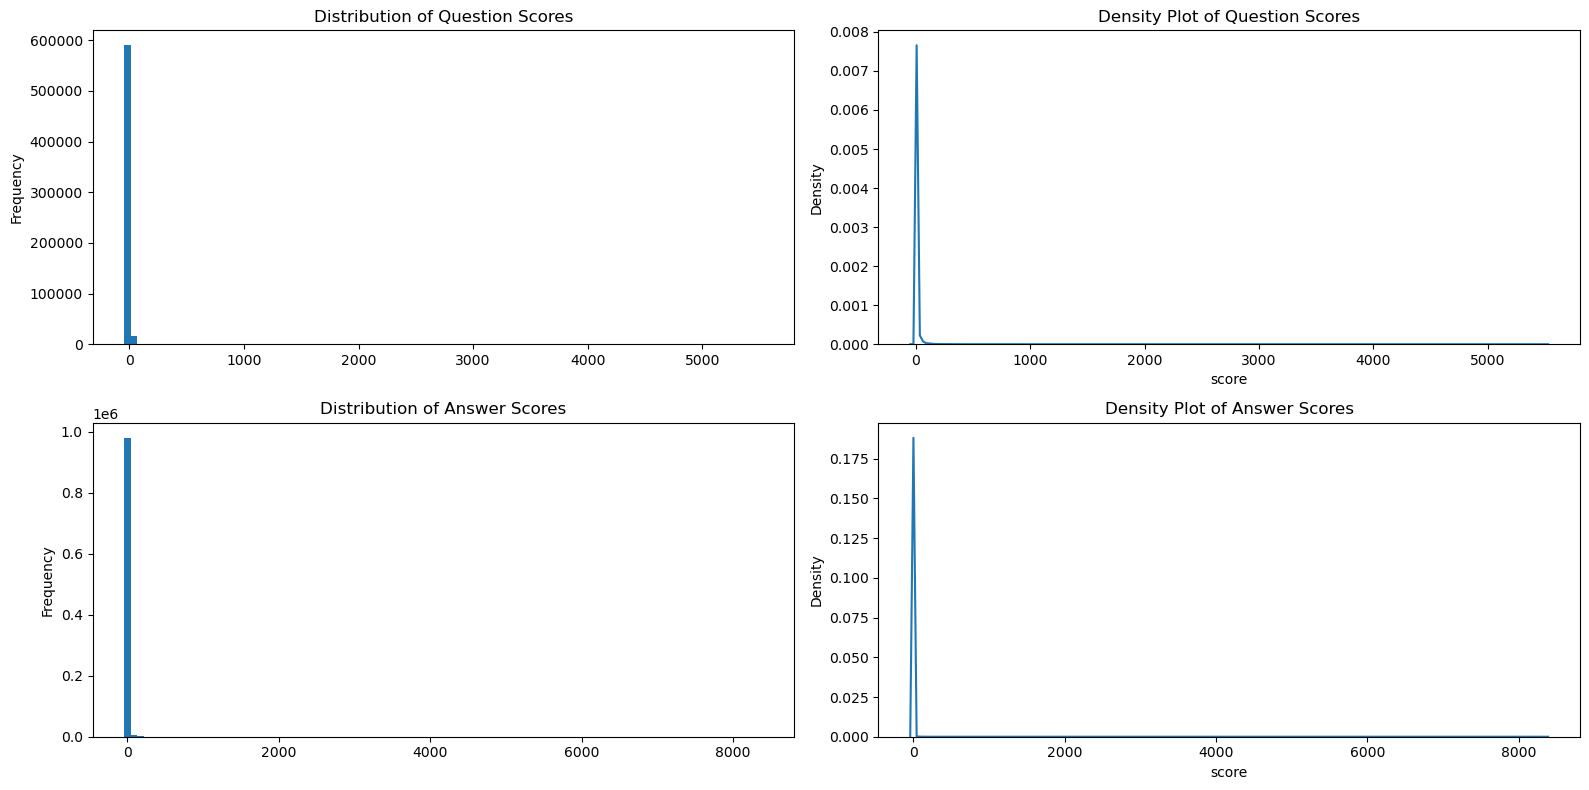

In [124]:
# Histogram and kds plot of score frequency questions and anwers
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Questions hist
ax0 = axs[0][0]

questions['score'].plot(kind='hist', bins=100, ax=ax0,
                        title='Distribution of Question Scores')

# Questions kde
ax1 = axs[0][1]

sns.kdeplot(questions['score'], ax=ax1)
ax1.set_title('Density Plot of Question Scores')

# Answers hist
ax2 = axs[1][0]

answers['score'].plot(kind='hist', bins=100, ax=ax2,
                      title='Distribution of Answer Scores')

# Answers kde
ax3 = axs[1][1]

sns.kdeplot(answers['score'], ax=ax3)
ax3.set_title('Density Plot of Answer Scores')

# Show
fig.tight_layout()
plt.show()

In [125]:
# Questions and answers score descriptives
ques_score_summary = questions['score'].describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99])
answer_score_summary = answers['score'].describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99])

print('Questions Scores Summary:')
print()
print(ques_score_summary)
print()
print('Answers Scores Summary:')
print()
print(answer_score_summary)

Questions Scores Summary:

count    607282.000000
mean          2.283137
std          19.285578
min         -44.000000
1%           -3.000000
5%           -1.000000
10%           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
90%           4.000000
95%           7.000000
99%          27.000000
max        5524.000000
Name: score, dtype: float64

Answers Scores Summary:

count    987122.000000
mean          3.028437
std          21.263246
min         -38.000000
1%           -1.000000
5%            0.000000
10%           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
90%           5.000000
95%           9.000000
99%          33.000000
max        8384.000000
Name: score, dtype: float64


95% of questions have scores of 7 or lower. 95% of answers have scores of 9 or lower. There are some extreme outlying questions and answers with scores in the thousands. 5% of questions and 1% of answers have scores below 0.

In [126]:
# View question rows with scores > 99th percentile
print('Questions with score > 27 (99th percentile)')
questions[questions['score'] > 27]

Questions with score > 27 (99th percentile)


,id,owner_user_id,creation_date,score,title,body,body_normalized,title_normalized,body_with_sentences,title_with_sentences,creation_year
2,535,154.0,2008-08-02 18:43:54+00:00,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,i'm starting work on a hobby project with a py...,continuous integration system for a python cod...,i'm starting work on a hobby project with a py...,continuous integration system for a python cod...,2008
4,683,199.0,2008-08-03 13:19:16+00:00,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,i don't remember whether i was dreaming or not...,using 'in' to match an attribute of python obj...,i don't remember whether i was dreaming or not...,using 'in' to match an attribute of python obj...,2008
5,742,189.0,2008-08-03 15:55:28+00:00,30,Class views in Django,"<p><a href=""http://www.djangoproject.com/"">Dja...",http www djangoproject com django view points ...,class views in django,http www.djangoproject.com django view points ...,class views in django,2008
7,773,207.0,2008-08-03 18:27:09+00:00,256,How do I use Python's itertools.groupby()?,<p>I haven't been able to find an understandab...,i haven't been able to find an understandable ...,how do i use python's itertools groupby,i haven't been able to find an understandable ...,how do i use python's itertools.groupby,2008
8,972,145.0,2008-08-04 02:17:51+00:00,364,Adding a Method to an Existing Object Instance,<p>I've read that it is possible to add a meth...,i've read that it is possible to add a method ...,adding a method to an existing object instance,i've read that it is possible to add a method ...,adding a method to an existing object instance,2008
...,...,...,...,...,...,...,...,...,...,...,...
597533,39779538,178732.0,2016-09-29 20:35:58+00:00,35,"How to get lineno of ""end-of-statement"" in Pyt...",<p>I am trying to work on a script that manipu...,i am trying to work on a script that manipulat...,how to get lineno of end of statement in pytho...,i am trying to work on a script that manipulat...,how to get lineno of end of statement in pytho...,2016
599214,39843488,336527.0,2016-10-04 03:00:56+00:00,41,How to make an integer larger than any other i...,<p>Note: while the accepted answer achieves th...,note while the accepted answer achieves the re...,how to make an integer larger than any other i...,note while the accepted answer achieves the re...,how to make an integer larger than any other i...,2016
600687,39903242,5149992.0,2016-10-06 18:29:51+00:00,32,Is there a more Pythonic way to combine an Els...,<p>I have a piece of code that searches AutoCA...,i have a piece of code that searches autocad f...,is there a more pythonic way to combine an els...,i have a piece of code that searches autocad f...,is there a more pythonic way to combine an els...,2016
602793,39980323,6260170.0,2016-10-11 14:59:23+00:00,72,Dictionaries are ordered in Python 3.6,"<p>Dictionaries are ordered in Python 3.6, unl...",dictionaries are ordered in python unlike in v...,dictionaries are ordered in python,dictionaries are ordered in python . unlike in...,dictionaries are ordered in python .,2016


In [127]:
# View answer rows with scores > 99th percentile
print('Ansers with score > 33 (99th percentile)')
answers[answers['score'] > 33]

Ansers with score > 33 (99th percentile)


,id,owner_user_id,creation_date,parent_id,score,body,body_normalized,body_with_sentences,creation_year
13,783,189.0,2008-08-03 18:40:09+00:00,773,52,<p>Can you show us your code?</p>\n\n<p>The ex...,can you show us your code the example on the p...,can you show us your code the example on the p...,2008
19,1484,2089740.0,2008-08-04 18:34:45+00:00,1476,57,<pre><code>&gt;&gt;&gt; print int('01010101111...,print int ' ' print int ' ' another way,print int ' ' print int ' ' another way.,2008
24,1857,2089740.0,2008-08-05 03:27:03+00:00,1854,341,<pre><code>&gt;&gt;&gt; import os\n&gt;&gt;&gt...,import os print os name posix import platform ...,import os print os.name posix import platform ...,2008
26,1871,216.0,2008-08-05 03:57:22+00:00,1854,112,"<p>Dang -- lbrandy beat me to the punch, but t...",dang lbrandy beat me to the punch but that doe...,dang lbrandy beat me to the punch but that doe...,2008
27,1879,116.0,2008-08-05 04:13:53+00:00,1854,91,<p>For the record here's the results on Mac:</...,for the record here's the results on mac impor...,for the record here's the results on mac impor...,2008
...,...,...,...,...,...,...,...,...,...
970166,39619467,1204143.0,2016-09-21 14:30:11+00:00,39618943,287,<p>The simple answer is because <code>3*0.1 !=...,the simple answer is because due to quantizati...,the simple answer is because . . due to quanti...,2016
977244,39843523,674039.0,2016-10-04 03:04:16+00:00,39843488,61,"<p>Since python integers are unbounded, you ha...",since python integers are unbounded you have t...,since python integers are unbounded you have t...,2016
979093,39903519,3155933.0,2016-10-06 18:45:36+00:00,39903242,63,<p>Use <code>dict.get()</code> which will retu...,use dict get which will return the value assoc...,use dict.get which will return the value assoc...,2016
981661,39980744,4952130.0,2016-10-11 15:17:53+00:00,39980323,57,<blockquote>\n <p>How does the Python 3.6 dic...,blockquote how does the python dictionary impl...,blockquote how does the python . dictionary im...,2016


### Distribution of reviews over time

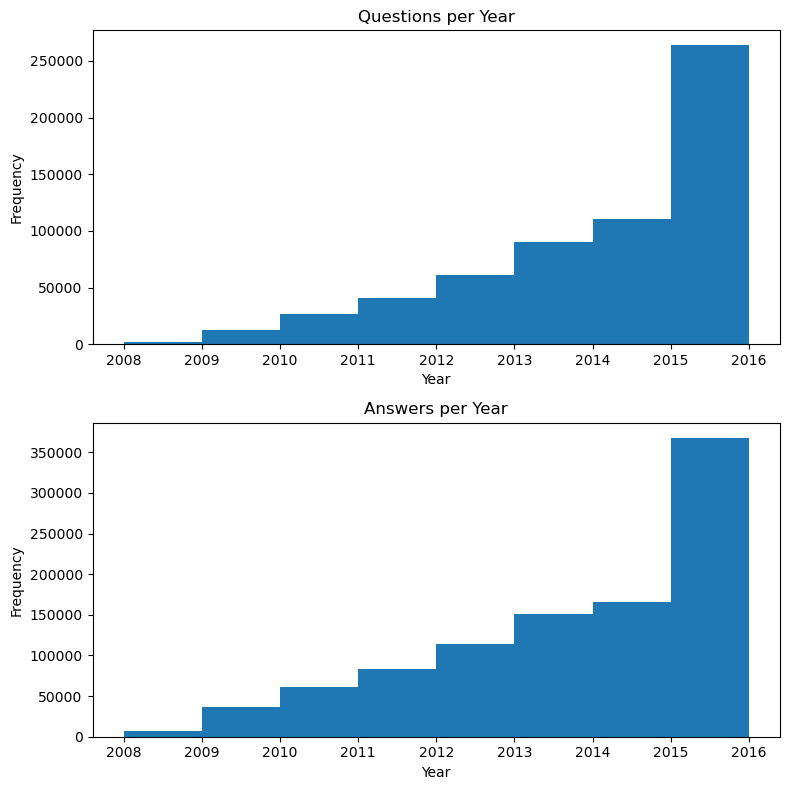

In [128]:
# Subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Questions per year
ax0 = axs[0]

questions['creation_year'].plot(kind='hist', ax=ax0,
                                title='Questions per Year',
                                xlabel='Year', bins=8)

# Answers per year
ax1 = axs[1]

answers['creation_year'].plot(kind='hist', ax=ax1,
                              title='Answers per Year',
                              xlabel='Year', bins=8)

# Display
fig.tight_layout()
plt.show()

Number of questions and answers are increasing over time.

### Wordcloud

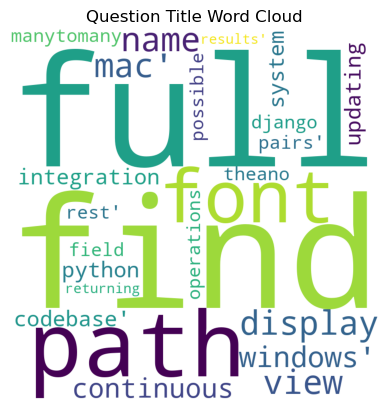

In [129]:
# Quesiton title word could
questions_title = questions['title_normalized'].values
stopwords = STOPWORDS

title_wordcloud = WordCloud(width=800, height=800,
                                background_color='white',
                                stopwords=stopwords,
                                min_font_size=10,
                                min_word_length=4,
                                random_state=123).generate(str(questions_title))

plt.imshow(title_wordcloud)

plt.title('Question Title Word Cloud')
plt.axis('off')

plt.show()

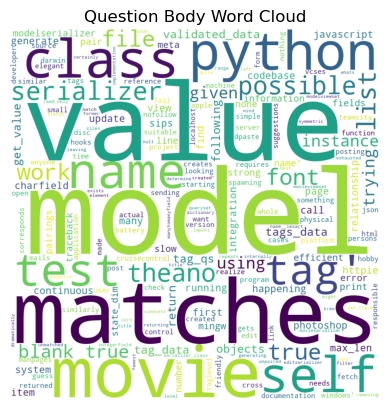

In [130]:
# Question body word cloud
questions_text = questions['body_normalized'].values

questions_wordcloud = WordCloud(width=800, height=800,
                                background_color='white',
                                stopwords=stopwords,
                                min_font_size=10,
                                min_word_length=4,
                                random_state=123).generate(str(questions_text))

plt.imshow(questions_wordcloud)

plt.title('Question Body Word Cloud')
plt.axis('off')

plt.show()

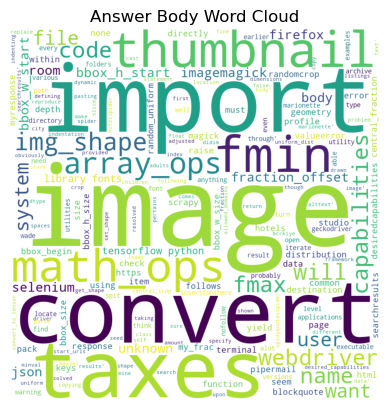

In [131]:
# Answer body word cloud
answers_text = answers['body_normalized'].values

answers_wordcloud = WordCloud(width=800, height=800,
                                background_color='white',
                                stopwords=stopwords,
                                min_font_size=10,
                                min_word_length=4,
                                random_state=123).generate(str(answers_text))

plt.imshow(answers_wordcloud)

plt.title('Answer Body Word Cloud')
plt.axis('off')

plt.show()

### Answers per question

<Axes: title={'center': 'Answers per Question'}, xlabel='Number of Answers', ylabel='Frequency of Answer Count'>

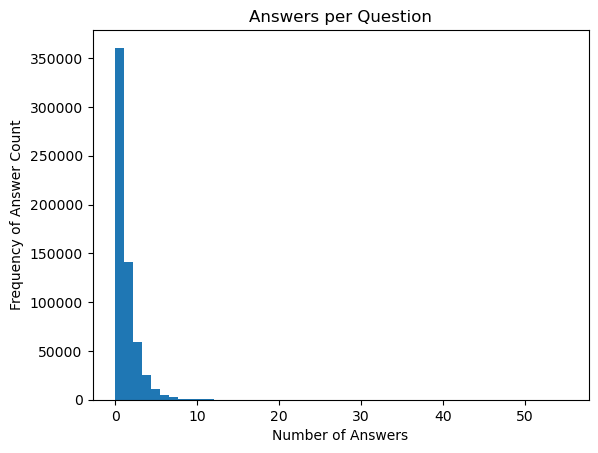

In [132]:
# Dataframe of count answers per question
answers_per_question = df_QA.groupby('id_q')['body_a'].count().reset_index().rename(columns={'body_a':'answer_count'})

answers_per_question['answer_count'].plot(kind='hist', bins=50,
                                          title='Answers per Question', 
                                          xlabel='Number of Answers',
                                          ylabel='Frequency of Answer Count')

In [133]:
# Descriptives of answers per question
print('Answers per Question Descriptives')
answers_per_question['answer_count'].describe(percentiles=[0.05, 0.10, 0.25, 0.75, 0.90, 0.95])

Answers per Question Descriptives


count    607282.000000
mean          1.625475
std           1.381757
min           0.000000
5%            0.000000
10%           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
90%           3.000000
95%           4.000000
max          55.000000
Name: answer_count, dtype: float64

### Words per question and answer

In [134]:
df_QA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055166 entries, 0 to 1055165
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   id_q                   1055166 non-null  int64              
 1   owner_user_id_q        1041567 non-null  float64            
 2   creation_date_q        1055166 non-null  datetime64[ns, UTC]
 3   score_q                1055166 non-null  int64              
 4   title                  1055166 non-null  object             
 5   body_q                 1055166 non-null  object             
 6   body_normalized_q      1055166 non-null  object             
 7   title_normalized       1055166 non-null  object             
 8   body_with_sentences_q  1055166 non-null  object             
 9   title_with_sentences   1055166 non-null  object             
 10  creation_year_q        1055166 non-null  int32              
 11  id_a                   9

In [135]:
# Add word count column
def word_count(text):
    wc = len(text.split())
    return wc


df_QA['answer_length'] = df_QA['body_normalized_a'].dropna().apply(word_count)
df_QA['question_length'] = df_QA['body_normalized_q'].dropna().apply(word_count)


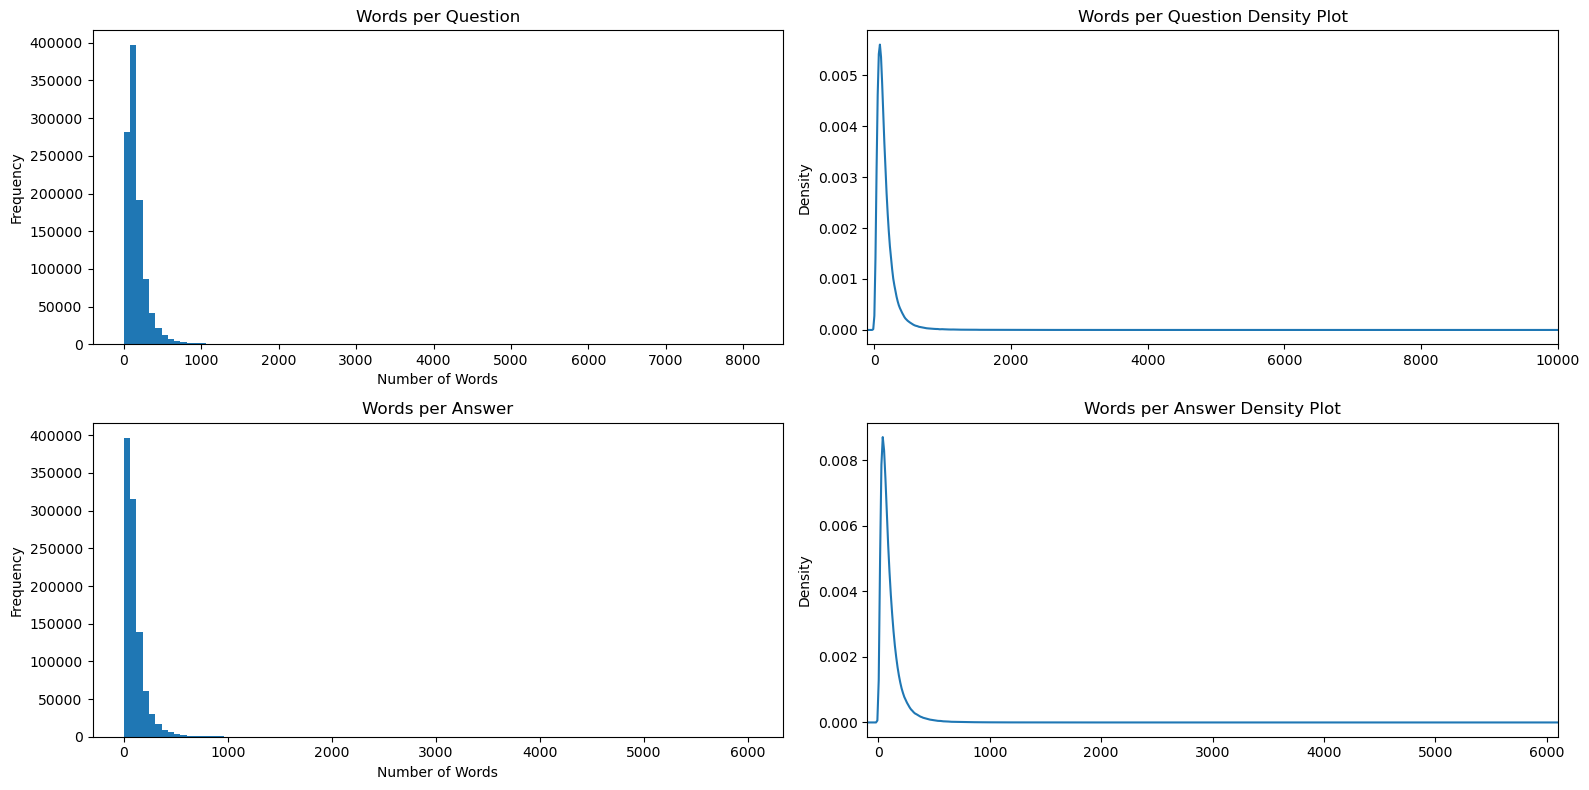

In [136]:
# Plot word count per question and per answer
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

ax0 = axs[0][0]

df_QA['question_length'].plot(kind='hist', ax=ax0,
                              title='Words per Question',
                              xlabel='Number of Words',
                              bins=100)

ax1 = axs[0][1]

df_QA['question_length'].plot(kind='kde', ax=ax1,
                              title='Words per Question Density Plot',
                              xlabel='Number of Words')

ax1.set_xlim(-100, 10000)

ax2 = axs[1][0]

df_QA['answer_length'].plot(kind='hist', ax=ax2,
                            title='Words per Answer',
                            xlabel='Number of Words',
                            bins=100)

ax3 = axs[1][1]

df_QA['answer_length'].plot(kind='kde', ax=ax3,
                            title='Words per Answer Density Plot',
                            xlabel='Number of Words')

ax3.set_xlim(-100, 6100)

fig.tight_layout()
plt.show()

In [137]:
# Descriptives of words per question and answer
print('Words per Question Descriptives')
print()
print(df_QA['question_length'].describe(percentiles=[0.05, 0.10, 0.25, 0.75, 0.90, 0.95]))
print()

print('Words per Answer Descriptives')
print()
print(df_QA['answer_length'].describe(percentiles=[0.05, 0.10, 0.25, 0.75, 0.90, 0.95]))

Words per Question Descriptives

count    1.055166e+06
mean     1.678182e+02
std      1.673463e+02
min      0.000000e+00
5%       3.800000e+01
10%      5.000000e+01
25%      7.900000e+01
50%      1.260000e+02
75%      2.020000e+02
90%      3.170000e+02
95%      4.220000e+02
max      8.111000e+03
Name: question_length, dtype: float64

Words per Answer Descriptives

count    987122.000000
mean        104.600107
std         110.399916
min           0.000000
5%           18.000000
10%          25.000000
25%          42.000000
50%          74.000000
75%         129.000000
90%         212.000000
95%         287.000000
max        6038.000000
Name: answer_length, dtype: float64


95%+ of questions and answers have less than 512 words.

## **QA Models**

### Subset data for questions with answers and scores above 0

In [138]:
# Subset for Q & A with positive scores
df_QA = df_QA[(df_QA['score_a'] >= 0) & (df_QA['score_q'] >= 0)]

print('Answer Score Descriptives')
print(df_QA['score_a'].describe())
print()
print('Question Score Descriptives')
print(df_QA['score_q'].describe())

Answer Score Descriptives
count    913099.000000
mean          3.239337
std          22.090040
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max        8384.000000
Name: score_a, dtype: float64

Question Score Descriptives
count    913099.000000
mean          7.769584
std          65.424836
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max        5524.000000
Name: score_q, dtype: float64


All question and answer scores now have a minimum of 0.

In [139]:
# Delete questions with no answers
df_QA = df_QA.dropna(axis=0, subset=['body_a']).reset_index(drop=True)

df_QA.isna().sum()

id_q                         0
owner_user_id_q          12945
creation_date_q              0
score_q                      0
title                        0
body_q                       0
body_normalized_q            0
title_normalized             0
body_with_sentences_q        0
title_with_sentences         0
creation_year_q              0
id_a                         0
owner_user_id_a           4969
creation_date_a              0
parent_id                    0
score_a                      0
body_a                       0
body_normalized_a            0
body_with_sentences_a        0
creation_year_a              0
answer_length                0
question_length              0
dtype: int64

In [140]:
# Remaining data
print('Merged QA after dropping invalid QA pairs:')
print()
df_QA.info()

Merged QA after dropping invalid QA pairs:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913099 entries, 0 to 913098
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   id_q                   913099 non-null  int64              
 1   owner_user_id_q        900154 non-null  float64            
 2   creation_date_q        913099 non-null  datetime64[ns, UTC]
 3   score_q                913099 non-null  int64              
 4   title                  913099 non-null  object             
 5   body_q                 913099 non-null  object             
 6   body_normalized_q      913099 non-null  object             
 7   title_normalized       913099 non-null  object             
 8   body_with_sentences_q  913099 non-null  object             
 9   title_with_sentences   913099 non-null  object             
 10  creation_year_q        913099 non-null  int32              


There are 913,099 remaining Q/A pairs where both question and answer have scores > 0 and every question has at least one answer.

### BERT

#### Create context by joining answers

In [141]:
# Join all answers into a context doc/object
context = ' '.join(df_QA['body_normalized_a'])

In [142]:
# Context word count
context_wc = len(context.split())

print(f'Context word count: {context_wc}')

Context word count: 96574040


#### BERT QA Model

In [143]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Model with all answers as context
result: got answer length error

In [144]:
# Test Question
question = 'what is pandas?'
answer_text = context

In [145]:
# BERT QA Answer
start_time = time.time()

input_ids = tokenizer.encode(question, answer_text)

attention_mask = [1] * len(input_ids)

output = model(torch.tensor([input_ids]), attention_mask=torch.tensor([attention_mask]))

start_index = torch.argmax(output[0][0, :len(input_ids) - input_ids.index(tokenizer.sep_token_id)])
end_index = torch.argmax(output[1][0, :len(input_ids) - input_ids.index(tokenizer.sep_token_id)])

answer = tokenizer.decode(input_ids[start_index:end_index + 1], skip_special_tokens=True)

end_time = time.time()

computation_time = end_time - start_time

print(f'Answer: {answer}')
print(f'Computation Time: {computation_time}')

KeyboardInterrupt: 

#### Model with specific answer as context
result: got an answer!

In [ ]:
# Choose row 10
display(df_QA.loc[10])

id_q                                                               535
owner_user_id_q                                                  154.0
creation_date_q                              2008-08-02 18:43:54+00:00
score_q                                                             40
title                Continuous Integration System for a Python Cod...
body_q               <p>I'm starting work on a hobby project with a...
body_normalized_q    i'm starting work on a hobby project with a py...
title_normalized     continuous integration system for a python cod...
creation_year_q                                                   2008
id_a                                                           61746.0
owner_user_id_a                                                 6372.0
creation_date_a                              2008-09-15 00:11:21+00:00
parent_id                                                        535.0
score_a                                                           13.0
body_a

In [ ]:
# Ask a relevant question for row 10
question = 'how to do hobby project?'
answer_text = df_QA.loc[10, 'body_a']

In [ ]:
# BERT QA with row 10
start_time = time.time()

input_ids = tokenizer.encode(question, answer_text)

attention_mask = [1] * len(input_ids)

output = model(torch.tensor([input_ids]), attention_mask=torch.tensor([attention_mask]))

start_index = torch.argmax(output[0][0, :len(input_ids) - input_ids.index(tokenizer.sep_token_id)])
end_index = torch.argmax(output[1][0, :len(input_ids) - input_ids.index(tokenizer.sep_token_id)])

answer = tokenizer.decode(input_ids[start_index:end_index + 1], skip_special_tokens=True)

end_time = time.time()

computation_time = end_time - start_time

print(f'Answer: {answer}')
print(f'Computation Time: {computation_time:.2f} seconds')

Answer: build it yourself
Computation Time: 1.84 seconds


#### Try context of 100 answers

result: answer text too long

In [ ]:
# context 100 answers
question = 'What is python?'
answer_text = ' '.join(df_QA.loc[0:100, 'body_normalized_a'])

open up a terminal applications utilities terminal and type this in locate insertfonthere br this will spit out every file that has the name you want warning there may be alot to wade through i haven't been able to find anything that does this directly i think you'll have to iterate through the various font folders on the system system library fonts library fonts and there can probably be a user level directory as well library fonts unfortunately the only api that isn't de cated is located in the applicationservices framework which doesn't have a bridge support file and thus isn't available in the bridge if you're wanting to use ctypes you can use atsfontgetfilereference after looking up the atsfontref cocoa doesn't have any native support at least as of for getting the location of a font there must be a method in cocoa to get a list of fonts then you would have to use the pyobjc bindings to call it depending on what you need them for you could probably just use something like the foll

In [ ]:
# BERT QA with context 100 answers
start_time = time.time()

input_ids = tokenizer.encode(question, answer_text)

attention_mask = [1] * len(input_ids)

output = model(torch.tensor([input_ids]), attention_mask=torch.tensor([attention_mask]))

start_index = torch.argmax(output[0][0, :len(input_ids) - input_ids.index(tokenizer.sep_token_id)])
end_index = torch.argmax(output[1][0, :len(input_ids) - input_ids.index(tokenizer.sep_token_id)])

answer = tokenizer.decode(input_ids[start_index:end_index + 1], skip_special_tokens=True)

end_time = time.time()

computation_time = end_time - start_time

print(f'Answer: {answer}')
print(f'Computation Time: {computation_time:.2f} seconds')

RuntimeError: The expanded size of the tensor (6736) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [1, 6736].  Tensor sizes: [1, 512]

#### Find similar questions

In [151]:
# Get embeddings for data set questions
start_time = time.time()

questions = df_QA.loc[0:10000, 'body_with_sentences_q']

model = SentenceTransformer('bert-base-nli-mean-tokens')

ques_embeddings = model.encode(questions)

end_time = time.time()

computation_time = end_time - start_time

print(f'Question Embeddings Shape: {ques_embeddings.shape}')
print(f'Computation Time: {computation_time:.2f} seconds')

Question Embeddings Shape: (10001, 768)
Computation Time: 1202.91 seconds


In [171]:
# Use cosine distance to find similar questions
start_time = time.time()

new_question = 'What is pandas?'

model = SentenceTransformer('bert-base-nli-mean-tokens')

new_question_embeddings = model.encode(new_question)

similarity_scores = cosine_similarity([new_question_embeddings],
                                       ques_embeddings)

best_index = np.argmin(similarity_scores)

end_time = time.time()

computation_time = end_time - start_time

best_question = df_QA.loc[best_index, 'body_with_sentences_q']
best_answer = df_QA.loc[best_index, 'body_with_sentences_a']

print('Question:')
print()
print(best_question)
print()
print('Answer:')
print()
print(best_answer)
print()
print(f'Best Index: {best_index}')
print()
print(f'Computation Time: {computation_time:.2f} seconds')

Question:

so when playing with the development i can just set settings.debug to true and if an error occures i can see it nicely formatted with good stack trace and request information. but on kind of production site i'd rather use debug false and show visitors some standard error page with information that i'm working on fixing this bug at this moment br at the same time i'd like to have some way of logging all those information stack trace and request info to a file on my server so i can just output it to my console and watch errors scroll email the log to me every hour or something like this. what logging solutions would you recomend for a django site that would meet those simple requirements i have the application running as fcgi server and i'm using apache web server as frontend although thinking of going to lighttpd .

Answer:

well when debug false django will automatically mail a full traceback of any error to each person listed in the admins setting which gets you notificatio

In [172]:
start_time = time.time()

bert_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

input_ids = bert_tokenizer.encode(question, df_QA.loc[5822, 'body_a'])

attention_mask = [1] * len(input_ids)

output = bert_model(torch.tensor([input_ids]), attention_mask=torch.tensor([attention_mask]))

start_index = torch.argmax(output[0][0, :len(input_ids) - input_ids.index(tokenizer.sep_token_id)])
end_index = torch.argmax(output[1][0, :len(input_ids) - input_ids.index(tokenizer.sep_token_id)])

answer = tokenizer.decode(input_ids[start_index:end_index + 1], skip_special_tokens=True)

end_time = time.time()

computation_time = end_time - start_time

print(f'Answer: {answer}')
print(f'Computation Time: {computation_time:.2f} seconds')

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Answer: 
Computation Time: 22.83 seconds


In [ ]:
# Similar question function
def find_similar_question(question, df, question_column):
    new_question_embeddings = model.encode(new_question)

    similarity_scores = cosine_similarity([new_question_embeddings],
                                        ques_embeddings)

    best_index = np.argmin(similarity_scores)

    print(f'Posed Question: {question}')
    print(f'Most Similar Question: {df.loc[best_index, question_column]})

# Try new questions
find_similar_question('What is python?', df_QA, 'body_with_sentences_q')

### Question Answer Function

In [ ]:
def question_answer():
    # Text normaliztion
    def normalize_text(text):
        text = text.lower()
        text = text.replace('<p>', ' ')
        text = text.replace('</p>', ' ')
        text = text.replace('\n', ' ')
        text = text.replace('<a', ' ')
        text = text.replace('</a>', ' ')
        text = text.replace('href=', ' ')
        text = text.replace('</code', ' ')
        text = text.replace('</pre>', ' ')
        text = text.replace('<code>', ' ')
        text = text.replace('jpeg', ' ')
        text = text.replace('jpg', ' ')
        text = text.replace('pre', ' ')
        text = text.replace('pdf', ' ')
        text = re.sub(r"[^a-zA-z']", ' ', text)
        text = text.split()
        text = " ".join(text)
    
        return text
    
    def bert_qa(text):
        # ! DEFINE BERT QA FUNCTION
        text
        
        return text
    
    # User input question 
    question = input('Question:')
    
    # Normalize Question
    question_norm = normalize_text(question)
    
    # Use bert model to answer question
    answer = bert_qa(question_norm)
    
    # Print answer
    print(f'Normalized quesiton: {answer}')
    
    # User vote
    user_vote = 0
    
    vote = input('Was this question helpful? (y/n)')
    
    # ! ADD VOTE TO DATAFRAME COLUMN
    if vote == 'y':
        user_vote += 1
    elif vote =='n':
        user_vote -= 1
    else:
        vote = input('Please choose on of these options (y/n):')
        
    return user_vote

In [ ]:
question_answer()

Normalized quesiton: hello


0